### АНАЛИТИЧЕСКОЕ РЕШЕНИЕ задачи линейной регрессии С ПОМОЩЬЮ NUMPY

Вот какие этапы нам предстоит пройти, чтобы построить свою модель:

1. Загрузить данные и проанализировать датасет на предмет пропусков.
2. Подготовить данные для подачи в модель: избавиться от пропусков, если они есть, и перекодировать категориальные признаки, если они представлены текстом.
3. Построить модель. Будем строить несколько моделей линейной регрессии: первую — на одном признаке, вторую — на всех доступные признаках.
4. Оценить качество модели.

In [59]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
%matplotlib inline
plt.style.use('seaborn') #установка стиля matplotlib

C:\Users\killr\AppData\Local\Temp\ipykernel_2716\546158159.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #установка стиля matplotlib


In [60]:
from sklearn.datasets import load_boston 
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the 

In [61]:
#создаём DataFrame из загруженных numpy-матриц
boston_data = pd.DataFrame(
    data=boston.data, #данные
    columns=boston.feature_names #наименования столбцов
)
#добавляем в таблицу столбец с целевой переменной
boston_data['MEDV'] = boston.target
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [62]:
boston_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


Давайте начнём с простого. Построим линейную регрессию на одном признаке. Выберем признак, который имеет наиболее высокую линейную взаимосвязь. Для этого рассчитаем корреляцию признаков с целевой переменной и выберем наиболее влиятельный.

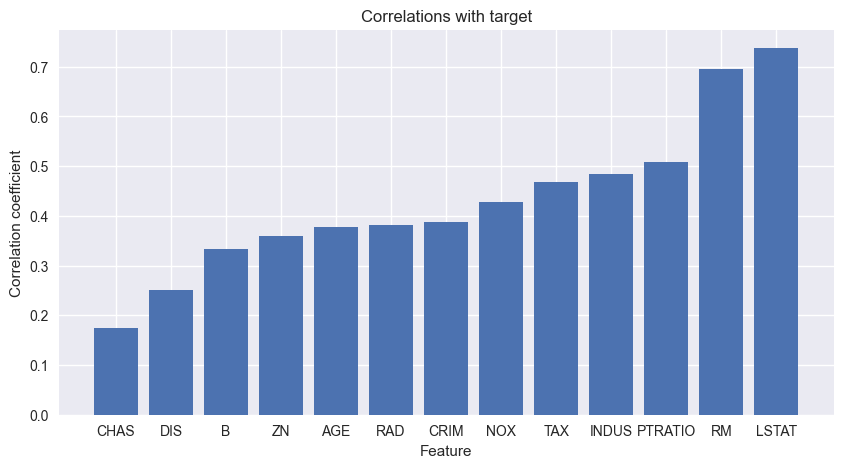

In [63]:
#Вычисляем модуль корреляции
corr_with_target = boston_data.corr()['MEDV'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('MEDV')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

In [64]:
X = boston_data[['LSTAT']] #матрица наблюдений
y = boston_data['MEDV'] #вектор правильных ответов
X.head()
#y.head()

,LSTAT
0,4.98
1,9.14
2,4.03
3,2.94
4,5.33


In [65]:
def linear_regression(X, y):
    #Создаём вектор из единиц
    ones = np.ones(X.shape[0])
    #Добавляем вектор к таблице первым столбцом
    X = np.column_stack([ones, X])
    #Вычисляем обратную матрицу Q (@ - это матричное умножение)
    Q = np.linalg.inv(X.T @ X)
    #Вычисляем вектор коэффициентов
    w = Q @ X.T @ y
    return w

In [66]:
#Вычисляем параметры линейной регрессии
w = linear_regression(X, y)
#Выводим вычисленные значения параметров в виде вектора
print('Vector w: {}'.format(w))
#Выводим параметры с точностью до двух знаков после запятой
print('w0: {:.2f}'.format(w[0]))
print('w1: {:.2f}'.format(w[1]))
# Vector w: [34.55384088 -0.95004935]
# w0: 34.55
# w1: -0.95

Vector w: [34.55384088 -0.95004935]
w0: 34.55
w1: -0.95


In [67]:
#Задаём процент низкостатусного населения
x_example = 5.18 
#Делаем предсказание
y_predict = w[0] + w[1] * x_example
print('Predicted value: {:.2f}'.format(float(y_predict)))
#Predicted value: 29.63

Predicted value: 29.63


Давайте напишем функцию plot_regression_2d(), у которой будет три обязательных аргумента (матрица наблюдений X, столбец правильных ответов y и столбец с предсказаниями модели y_pred) и два аргумента по умолчанию (xlabel — подпись оси абсцисс и ylabel — подпись оси ординат).

In [68]:
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    fig, ax = plt.subplots(figsize=(8, 4)) #фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.5, label='Sample data') #диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model') #линейный график
    ax.set_xlabel(xlabel) #название оси абсцисс
    ax.set_ylabel(ylabel) #название оси ординат
    ax.legend(facecolor='white', fontsize=11) #легенда

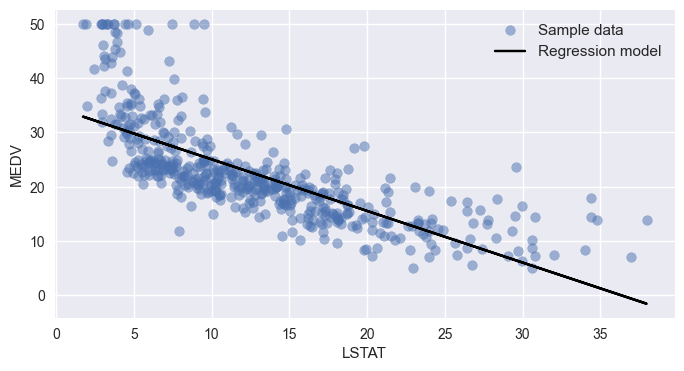

In [69]:
#Делаем предсказание для всех объектов из таблицы
y_predict = w[0] + w[1] * X
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

### АНАЛИТИЧЕСКОЕ РЕШЕНИЕ С ПОМОЩЬЮ SKLEARN

In [70]:
from sklearn import linear_model

В модуле находится класс LinearRegression, который реализует аналитическое решение линейной регрессии. Для обучения модели необходимо просто вызвать метод fit(), передав в него матрицу наблюдений X и вектор правильных ответов y.

In [71]:
#Создаём объект класса LinearRegression
lr_lstat = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_lstat.fit(X, y)
 
print('w0: {}'.format(lr_lstat.intercept_)) #свободный член w0
print('w1: {}'.format(lr_lstat.coef_)) #остальные параметры модели w1, w2, ..., wm
 
# w0: 34.55384087938311
# w1: [-0.95004935]

w0: 34.5538408793831
w1: [-0.95004935]


Модель обучена. А как сделать предсказание? Вручную записывать выражение для модели и подставлять коэффициенты? Конечно же, нет. Для этого есть метод predict(). В него необходимо передать матрицу наблюдений, для которых нужно сделать предсказание.

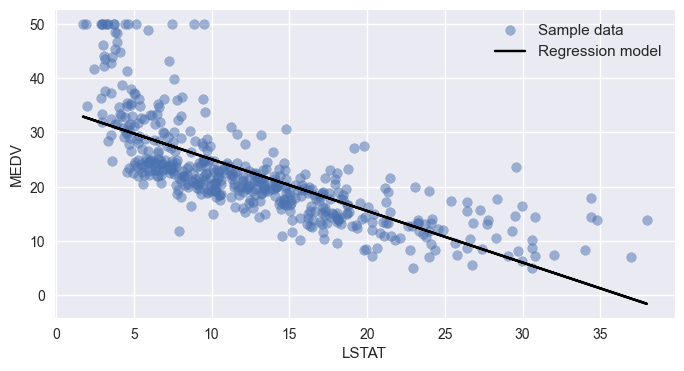

In [72]:
#Предсказываем медианную цену для всех участков из набора данных
y_predict = lr_lstat.predict(X)
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

А что, если мы хотим построить линейную регрессию, используя всю предоставленную информацию, то есть все 13 признаков? Не проблема! Нужно только расширить матрицу наблюдений , добавив в неё остальные признаки и снова обучить модель LinearRegression.

Давайте выберем из таблицы boston все столбцы, исключая столбец с целевой переменной (MEDV). Полученную матрицу X и вектор правильных ответов y отправляем в метод fit(), чтобы произвести подгонку и найти параметры модели.

In [73]:
#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']
#Создаём объект класса LinearRegression
lr_full = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_full.fit(X, y)

LinearRegression()

Для удобства составим DataFrame из коэффициентов   обученной модели, не забыв добавить к нему строку со свободным членом :

In [74]:
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': lr_full.coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr_full.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,-0.108011
1,ZN,0.046420
2,INDUS,0.020559
3,CHAS,2.686734
4,NOX,-17.766611
5,RM,3.809865
6,AGE,0.000692
7,DIS,-1.475567
8,RAD,0.306049
9,TAX,-0.012335


Итак, мы с вами построили две модели линейной регрессии: lr_lstat на одном признаке (LSTAT) и lr_full — на всех признаках в данных. Хотелось бы сравнить эти модели по их качеству. Может, нам достаточно только знаний о проценте низкостатусного населения, чтобы предсказать медианную цену?

Самая простая идея — визуализировать ошибки. Давайте построим коробчатые диаграммы ошибок моделей. Ошибки будем считать по формуле:

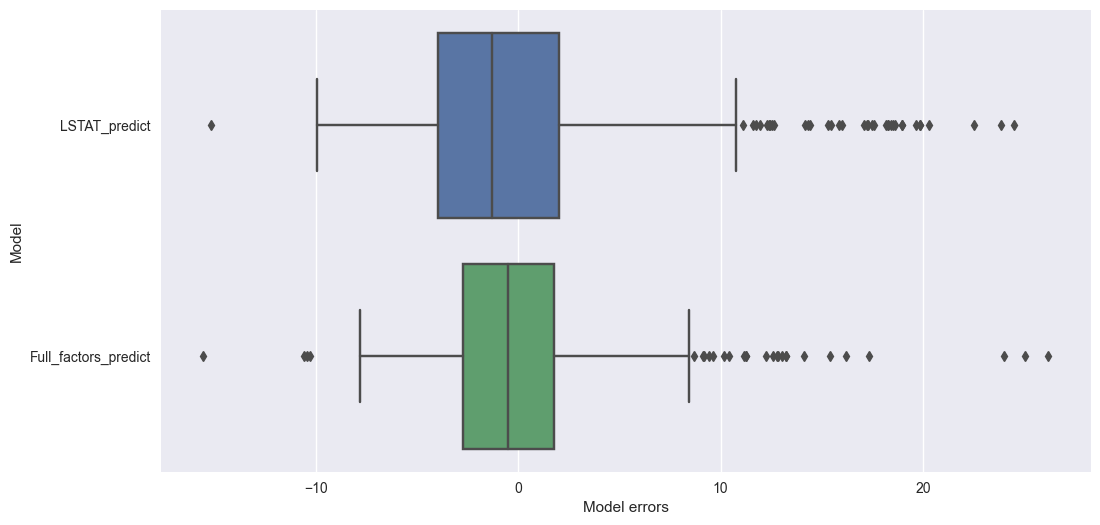

In [75]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на одном факторе LSTAT
y_errors_lstat = y - lr_lstat.predict(boston_data[['LSTAT']])
#Ошибки модели на всех факторах
y_errors_full = y - lr_full.predict(boston_data[features])
#Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'LSTAT_predict': y_errors_lstat, 
     'Full_factors_predict': y_errors_full
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [76]:
#Задание 2.7
#В ваших данных появился новый участок со следующими параметрами:
#CRIM         0.35114
#ZN           0.00000
#INDUS        7.38000
#CHAS         0.00000
#NOX          0.49300
#RM           6.04100
#AGE         49.90000
#DIS          4.72110
#RAD          5.00000
#TAX        287.00000
#PTRATIO     19.60000
#B          396.90000
#LSTAT        7.70000
#Сделайте предсказание медианной стоимости (MEDV) для данного участка c помощью модели lr_full. 
# Введите результат предсказания в тысячах долларов. Ответ округлите до второго знака после точки-разделителя.

In [77]:
new_house = np.array([0.35114, 0, 7.38000, 0, 0.49300, 6.04100, 49.90000, 4.72110, 5.00000, 287.00000, 19.60000, 396.90000, 7.70000, 1])
reg_coef = np.array(coef_df['Coefficients'])
np.dot(new_house, reg_coef)


22.869524474348104

In [78]:
#Задание 2.8
#Дан набор данных о стартапах и их прибыли (в долларах) в трёх различных штатах США.
#Столбцы:

#R&D Spend — расходы на исследования.
#Administration — административные расходы.
#Marketing Spend — расходы на маркетинг.
#State — штат.
#Profit — прибыль (целевой признак).
#Для обучения линейной регрессии используйте R&D Spend, Administration и Marketing Spend. Отделите факторы от целевой переменной.

#Обучите модель линейной регрессии методом наименьших квадратов с помощью библиотеки numpy (воспользуйтесь формулой из модуля).

#Чему равны коэффициенты линейной регрессии при признаках R&D Spend, Administration и Marketing Spend? 
# Ответ введите с точностью до второго знака после точки-разделителя.

In [79]:
df = pd.read_csv('50_Startups.csv')
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [81]:
#Пропусков нет, тип данных норм но нудным столбцам. Разделим данные.
X1 = df[['R&D Spend','Administration', 'Marketing Spend']]
y1 = df[['Profit']]

In [82]:
startup_full = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
startup_full.fit(X1, y1)

LinearRegression()

In [83]:
startup_full.coef_

array([[ 0.80571505, -0.02681597,  0.02722806]])

### МЕТРИКИ РЕГРЕССИИ

**Средняя абсолютная ошибка — MAE (Mean Absolute Error)**

Среднеарифметическое суммы моделей отклонений на каждом наблюдении.

**Средняя абсолютная ошибка в процентах — MAPE (Mean Absolute Percent Error)**

Среднееарифметическое отношений отклонений на каждойм наблюдении к истинному значению наблюдений в %

**Средняя квадратическая ошибка — MSE**

Среднеарифметическое квадратов разностей наблюдений и данных модели

**Корень из средней квадратической ошибки — RMSE (Root Mean Squared Error)**

Это просто корень квардатный из MSE

**Коэффициент детерминации ($R^2$)**

1 - MSE / MSE(mean)

где MSE(mean) - Это MSE для прогноза = среднее по вектору правильных ответов

Удовлетворительным  считается показатель выше 0.5: чем ближе к 1, тем лучше. Отрицательные значения  говорят о том, что построенная модель настолько плоха, что лучше было бы присвоить всем ответам среднее значение.

##### Функции расчета метрики в модуле METRICS БИБЛИОТЕКИ SKLEARN

1. MAE - mean_absolute_error()
2. MAPE - mean_absolute_percentage_error()
3. MSE = mean_square_error()
4. RMSE -  MSE ** (1/2) (отдельное нет функции)
5. $R^2$ - r2_score()

### РАСЧЁТ МЕТРИК НА PYTHON

Начнём с модели lr_lstat: сделаем предсказание на основании признака LSTAT и передадим истинные и предсказанные медианные цены в функции для расчёта метрик:

In [85]:

from sklearn import metrics
#Делаем предсказание по признаку LSTAT
y_predict_lstat = lr_lstat.predict(boston_data[['LSTAT']])

#Рассчитываем MAE
print('MAE score: {:.3f} thou. $'.format(metrics.mean_absolute_error(y, y_predict_lstat)))
#Рассчитываем RMSE
print('RMSE score: {:.3f} thou. $'.format(np.sqrt(metrics.mean_squared_error(y, y_predict_lstat))))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_predict_lstat) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict_lstat)))

MAE score: 4.505 thou. $
RMSE score: 6.203 thou. $
MAPE score: 21.352 %
R2 score: 0.544


Проделываем ту же самую операцию для второй модели линейной регрессии, lr_full:

In [86]:
#Делаем предсказание по всем признакам
y_predict_full = lr_full.predict(boston_data[features])
#Рассчитываем MAE
print('MAE score: {:.3f} thou. $'.format(metrics.mean_absolute_error(y, y_predict_full)))
#Рассчитываем RMSE
print('RMSE score: {:.3f} thou. $'.format(np.sqrt(metrics.mean_squared_error(y, y_predict_full))))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_predict_full) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict_full)))

MAE score: 3.271 thou. $
RMSE score: 4.679 thou. $
MAPE score: 16.417 %
R2 score: 0.741


In [88]:
#Задание 3.2
#У вас есть истинные ответы y_true = [1.23, 2.35, 2.75] и предсказания модели y_pred = [1.01, 12.3, 2.74]. 
# Посчитайте метрику RMSE, ответ округлите до двух знаков после точки-разделителя.

y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]
np.sqrt(metrics.mean_squared_error(y_true, y_pred))


5.746042116100439

In [89]:
#Задание 3.3
#Чему равен коэффициент детерминации на следующих данных?
#Истинные ответы: y_true = [22.4, 20.6, 23.9, 22.0, 11.9]
#Предсказанные ответы: y_pred = [20.5, 20.2, 20.3, 19.0, 11.0]
#Ответ округлите до двух знаков после точки-разделителя.

y_true = [22.4, 20.6, 23.9, 22.0, 11.9]
y_pred = [20.5, 20.2, 20.3, 19.0, 11.0]
metrics.r2_score(y_true, y_pred)


0.707747874730212

### ЧИСЛЕННОЕ РЕШЕНИЕ НА PYTHON

In [90]:
from sklearn.datasets import load_boston 
boston = load_boston()
#создаём DataFrame из загруженных numpy-матриц
boston_data = pd.DataFrame(
    data=boston.data, #данные
    columns=boston.feature_names #наименования столбцов
)
#добавляем в таблицу столбец с целевой переменной
boston_data['MEDV'] = boston.target
boston_data.head()

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the 

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Обучим с помощью градиентного спуска линейную регрессию на одном факторе — LSTAT (процент низкостатусного населения) — и сравним результат с полученным ранее результатом МНК.

In [91]:
X = boston_data[['LSTAT']] #матрица наблюдений
y = boston_data['MEDV'] #вектор правильных ответов

Будем использовать реализацию стохастического градиентного спуска для линейной регрессии из библиотеки sklearn — SGDRegressor. Она находится в том же модуле linear_model.

У класса SGDRegressor есть множество параметров. Например, параметр random_state отвечает за число, на основе которого происходит генерация  случайных чисел. Напомним, в SGD случайность присутствует в инициализации параметров и выборе части из набора данных. Установив значение параметра random_state равным определённому числу, мы можем гарантировать одинаковые результаты работы метода при разных запусках. Пусть это будет число 42.

Для обучения используется метод fit(): он запускает работу градиентного спуска для поиска параметров, в него необходимо передать данные и правильные ответы.

In [92]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_lstat = linear_model.SGDRegressor(random_state=42)
#Обучаем модель — ищем параметры по методу SGD
sgd_lr_lstat.fit(X, y)

SGDRegressor(random_state=42)

Обучение завершено, параметры найдены. Давайте выведем их на экран. Для этого используются уже знакомые вам атрибуты coef_ и intercept_:

In [93]:
print('w0: {}'.format(sgd_lr_lstat.intercept_)) #свободный член w0
print('w1: {}'.format(sgd_lr_lstat.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: [34.33010969]
w1: [-0.96193242]


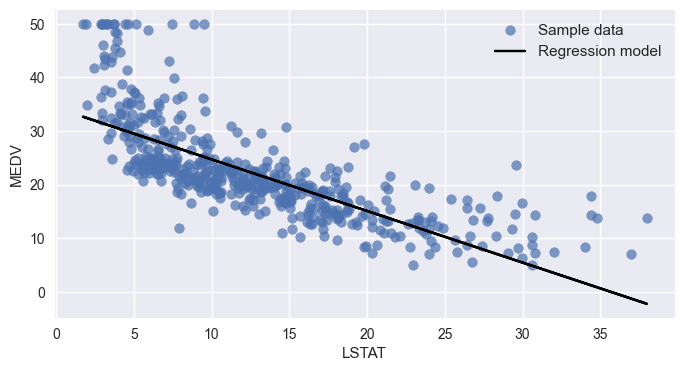

In [94]:
#функция для визуализации регрессии
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    fig, ax = plt.subplots(figsize=(8, 4)) #фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data') #диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model') #линейный график
    ax.set_xlabel(xlabel) #название оси абсцисс
    ax.set_ylabel(ylabel) #название оси ординат
    ax.legend(facecolor='white', fontsize=11) #легенда
#Предсказываем медианную цену для всех участков из набора данных
y_predict = sgd_lr_lstat.predict(X)
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

In [95]:
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))
# R2 score: 0.542

R2 score: 0.542


Теперь попробуем обучить многомерную линейную регрессию с помощью SGD. Как и раньше составим полную матрицу наблюдений  из всех факторов, которые нам даны. Обучим модель и выведем значения коэффициентов в виде DataFrame:

In [97]:
#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']
 
#Создаём объект класса линейной регрессии с SGD
sgd_lr_full = linear_model.SGDRegressor(random_state=42)
#Обучаем модель — ищем параметры по методу SGD
sgd_lr_full.fit(X, y)
 
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': sgd_lr_full.coef_})
#Составляем строчку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': sgd_lr_full.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,2.156857e+11
1,ZN,1.248446e+10
2,INDUS,7.277644e+09
3,CHAS,8.306154e+09
4,NOX,-8.413828e+09
5,RM,-3.148182e+10
6,AGE,8.685820e+10
7,DIS,-2.256141e+11
8,RAD,-4.683208e+10
9,TAX,1.892286e+09


Все коэффициенты имеют запредельные значения (9-11 степени числа 10). Это типичная картина расходящегося градиентного спуска: алгоритм не достиг точки минимума по каким-то причинам. Такие высокие значения коэффициентов означают, что модель является неустойчивой.

Давайте сделаем предсказание и выведем  $R^2$ для обученной модели:

In [98]:
#Предсказываем медианную цену для всех участков из набора данных
y_predict = sgd_lr_full.predict(X)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

# R2 score: -10590303862129977211224064.000

R2 score: -10590303862129979358707712.000


В чём же причина? Неужели SGD не справился с поиском 14 параметров (свободный член + 13 коэффициентов при факторах)?

Ответ очень простой — отсутствие масштабирования. Как мы уже говорили ранее, при использовании градиентного спуска и его модификаций очень важно масштабировать данные с помощью нормализации или стандартизации. Иначе алгоритм теряется в таком растянутом пространстве из-за неравномерных градиентов.

Давайте стандартизируем наши данные. Воспользуемся классом StandardScaler из модуля preprocessing библиотеки sklearn, который реализует стандартизацию.

In [100]:
from sklearn import preprocessing
 
#Инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()
#Производим стандартизацию
X_scaled = scaler.fit_transform(X)
#Составляем DataFrame из результата
X_scaled = pd.DataFrame(X_scaled, columns=features)
X_scaled.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501


In [101]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_full = linear_model.SGDRegressor(random_state=42)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_full.fit(X_scaled, y)
 
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': sgd_lr_full.coef_})
#Составляем строчку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': sgd_lr_full.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,-0.870552
1,ZN,0.947112
2,INDUS,-0.116802
3,CHAS,0.730289
4,NOX,-1.894276
5,RM,2.757578
6,AGE,-0.027846
7,DIS,-3.049237
8,RAD,1.957066
9,TAX,-1.305271


In [102]:
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_full.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

# R2 score: 0.740

R2 score: 0.740


У класса SGDRegressor, помимо random_state, есть ещё множество различных внешних параметров, которые можно настраивать. Со всем списком вы можете ознакомиться в документации. А мы приведём несколько самых важных:

loss — функция потерь. По умолчанию используется squared_loss — уже привычная нам MSE. Но могут использоваться и несколько других. Например, значение "huber" определяет функцию потерь Хьюбера. Эта функция менее чувствительна к наличию выбросов, чем MSE.

max_iter — максимальное количество итераций, выделенное на сходимость. Значение по умолчанию — 1000.

learning_rate — режим управления темпом обучения. Значение по умолчанию — 'invscaling'. Этот режим уменьшает темп обучения по формуле, которую мы рассматривали ранее: $\eta_t = \eta_0 / t^p$.

Есть ещё несколько режимов управления, о которых вы можете прочитать в документации.

Если вы не хотите, чтобы темп обучения менялся на протяжении всего обучения, то можете выставить значение параметра на "constant".

eta0 — начальное значение темпа обучения . Значение по умолчанию — 0.01.
Если параметр learning_rate="constant", то значение этого параметра будет темпом обучения на протяжении всех итераций.

power_t — значение мощности уменьшения  в формуле  $\eta_t = \eta_0 / t^p$. Значение по умолчанию — 0.25.

Давайте посмотрим, что будет, если выставить константный режим управления темпом обучения и задать ему более высокое значение, например 0.1:

In [103]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_bad = linear_model.SGDRegressor(
    learning_rate='constant', #режим темпа обучения — константа
    eta0=0.1, #начальное и постоянное значение темпа обучения
    random_state=42
)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_bad.fit(X_scaled, y)
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_bad.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

R2 score: -335415038359.635


SGD разошёлся из-за слишком высокого темпа обучения. 

Вот ещё один плохой пример. Что будет, если поставить слишком маленькое значение параметра eta0? Например, 0.000001.

In [104]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_bad2 = linear_model.SGDRegressor(
    learning_rate='constant', #режим темпа обучения — константа
    eta0=1e-6, #начальное и постоянное значение темпа обучения
    random_state=42
)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_bad2.fit(X_scaled, y)
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_bad2.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

R2 score: -1.578


c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


мы видим предупреждение (warning), которое говорит о том, что алгоритму не хватило количества итераций (max_iter), чтобы добраться до минимума. То есть SGD не дошёл до точки минимума из-за слишком низкого темпа обучения.

Так как модель линейной регрессии является довольно простой и исследованной, то значения параметров, которые обладают наибольшей эффективностью, уже установлены по умолчанию (аргументы по умолчанию), но бывают ситуации, когда поэкспериментировать с параметрами может быть полезно, чтобы попытаться повысить качество.

In [ ]:
#Задание 4.9
#Найдите в документации параметр, отвечающий на критерий остановки (по умолчанию он равен 0.001).
#Обучите SGDRegressor на датасете о домах в Бостоне с параметром остановки, равным 0.1, и random_state = 42. 
# Остальные параметры оставьте по умолчанию.

#Рассчитайте коэффициент детерминации . Ответ округлите до третьего знака после точки-разделителя. Сделайте вывод по полученным результатам.

In [106]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_bad2 = linear_model.SGDRegressor(
    tol = 0.1,
    random_state=42
)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_bad2.fit(X_scaled, y)
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_bad2.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

R2 score: 0.735


Вывод: мы просто остановились раньше в реализации алгоритма. Пожтому получили чуть меньшую точность

Если стоит задача одноразового обучения на всех данных, которые есть, и признаков немного (меньше 1 000), наш выбор — LinearRegression, так как МНК обеспечивает простое решение и гарантированную сходимость.

Если стоит задача непрерывного обучения модели в процессе её эксплуатации или количество признаков очень велико, наш выбор — SGDRegressor с возможностью корректировки параметров на новых данных.

### Дилемма смещения и разброса. Полиномиальные признаки. Регуляризация

In [107]:
from sklearn.datasets import load_boston 

boston = load_boston()
#создаём DataFrame из загруженных numpy-матриц
boston_data = pd.DataFrame(
    data=boston.data, #данные
    columns=boston.feature_names #наименования столбцов
)
#добавляем в таблицу столбец с целевой переменной
boston_data['MEDV'] = boston.target
 
#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the 

В sklearn для разделения выборки на тренировочную и тестовую есть функция train_test_split() из модуля model_selection. Данная функция принимает следующие аргументы:

X и y — таблица с примерами и ответами к ним.
random_state — число, на основе которого генерируются случайные числа. Тренировочная и тестовая выборка генерируются случайно. Чтобы эксперимент был воспроизводимым, необходимо установить этот параметр в конкретное значение.
test_size — доля тестовой выборки. Параметр определяет, в каких пропорциях будет разделена выборка. Стандартные значения: 70/30, 80/20.
Функция возвращает четыре объекта в следующем порядке: тренировочные примеры, тестовые примеры, тренировочные ответы и тестовые ответы. 

Итак, давайте разделим нашу выборку на тренировочную и тестовую в соотношении 70/30:

In [108]:
from sklearn.model_selection import train_test_split
#Разделяем выборку на тренировочную и тестовую в соотношении 70/30
#Устанавливаем random_state для воспроизводимости результатов 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
#Выводим результирующие размеры таблиц
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (354, 13) (354,)
Test: (152, 13) (152,)


Обучим линейную регрессию (с помощью МНК) на тренировочных данных и рассчитаем $R^2$ для тренировочных и тестовых данных:

In [109]:
#Создаём объект класса LinearRegression
lr_model = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model.fit(X_train, y_train)
 
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_model.predict(X_train)
#Делаем предсказание для тестовой выборки
y_test_predict = lr_model.predict(X_test)
 
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))

Train R^2: 0.743
Test R^2: 0.722


Это одно из свидетельств отсутствия переобучения. Это не удивительно, ведь линейная регрессия, построенная на 13 факторах, является довольно простой моделью: всего лишь 14 параметров, что очень мало по меркам машинного обучения. Риск переобучения возрастает с количеством факторов, которые участвуют в обучении модели.

Но что насчёт смещения? Самый простой способ оценить смещение и недообученность модели — посмотреть на значение метрики и интуитивно оценить её.

Может, наша модель слишком слабая?  0.722  — не слишком уж высокий показатель (напомним, максимум — 1). Возможно, стоит попробовать обучить более сложную модель. Например, можно построить модель полиномиальной регрессии.

### ПОЛИНОМИАЛЬНЫЕ ПРИЗНАКИ

По сути эта таже линейная регрессия, только мы увеличиваем число признаков, генерируя все степенные комбинации. Обычно использует сетепень не больше 3х. По факту мы получаем все равно какуюто гиперповерхность.

Построить полиномиальную регрессию в sklearn очень просто. Для начала необходимо создать полиномиальные признаки с помощью объекта класса PolynomialFeatures из модуля preprocessing. Это преобразователь, который позволит сгенерировать полиномиальные признаки любой степени и добавить их в таблицу. У него есть два важных параметра:

1. degree — степень полинома. По умолчанию используется степень 2.
2. include_bias — включать ли в результирующую таблицу столбец из единиц (x в степени 0). По умолчанию стоит True, но лучше выставить его в значение False, так как столбец из единиц и так добавляется в методе наименьших квадратов.

Для того чтобы подогнать генератор и рассчитать количество комбинаций степеней, мы используем метод fit(), а чтобы сгенерировать новую таблицу признаков, в которую будут включены полиномиальные признаки, используется метод transform(), в который нужно передать выборки:

In [110]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

(354, 104)
(152, 104)


Итак, мы сгенерировали новые тренировочные и тестовые наборы данных. В каждой таблице в дополнение к 13 изначальным признакам добавилась 91 полиномиальная комбинация степени 2.

В результате мы получили два numpy-массива:

In [111]:
print(type(X_train_poly))
print(type(X_test_poly))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Теперь попробуем скормить наши данные модели линейной регрессии, чтобы найти коэффициенты полинома по МНК-алгоритму:

In [112]:
#Создаём объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lr_model_poly.predict(X_test_poly)
 
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.929
Test R^2: 0.268


Это и есть переобучение модели. Из-за своей сложности (количества факторов) модель полностью адаптировалась под тренировочные данные, но взамен получила высокий разброс в показателях на данных, которые она не видела ранее. 

Однако не стоит расстраиваться — есть один замечательный метод, который сможет спасти нашу модель от переобучения, и это регуляризация.

### РЕГУЛЯРИЗАЦИЯ

Регуляризация — способ уменьшения переобучения моделей машинного обучения.

Идея регуляризации состоит в том, что мы намеренно пытаемся увеличить смещение модели, чтобы уменьшить разброс. Закон баланса в действии!

Но как можно увеличить смещение модели? Мы можем «наказывать» модель за обучение сложным взаимосвязям. 

Математически это будет очень простая операция — добавление к функции потерь некоторого штрафа.

Штраф — это дополнительное неотрицательное слагаемое в выражении для функции потерь, которое специально повышает ошибку.  За счёт этого слагаемого метод оптимизации (OLS или SGD) будет находить не истинный минимум функции потерь, а псевдоминимум.

Есть несколько способов добавления штрафа к функции потерь:

1. L1-регуляризация (Lasso) — добавление к функции потерь суммы модулей коэффициентов, умноженных на коэффициент регуляризации $\alpha$:

$L1(w) = MSE + \alpha  |w_j|$

2. 

$L2(w) = MSE + \alpha  \sum{w_j^2}$

Коэффициенты  (альфа) — это коэффициенты регуляризации. Они отвечают за то, насколько сильное смещение мы будем вносить в модель: чем оно больше , тем сильнее будет штраф за переобучение.

В заключение теоретической части хочется отметить, что на практике никогда не ясно, какой из методов регуляризации сработает лучше всего. Выход — пробовать оба метода и сравнивать результаты.

Практика показывает, что обучение линейной регрессии с большим количеством признаков рекомендуется производить на стандартизованных (нормализованных) данных.

Примечание. Часто возникает вопрос: как правильно проводить стандартизацию/нормализацию при наличии тренировочной и тестовой выборки?

Вы обучаете (fit()) преобразование на тренировочной выборке и используете его с одними и теми же параметрами на тренировочной и тестовой выборке (transform()). Если производить подгонку на каждой из выборок в отдельности, вы внесёте смещение в модель.

Стандартизацию (нормализацию) полезнее проводить перед генерацией полиномиальных признаков, иначе можно потерять масштаб полиномов.

Давайте предобработаем наши данные:

In [113]:
#Инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()
#Подгоняем параметры стандартизатора (вычисляем среднее и СКО)
scaler.fit(X_train)
#Производим стандартизацию тренировочной выборки
X_train_scaled = scaler.transform(X_train)
#Производим стандартизацию тестовой выборки
X_test_scaled = scaler.transform(X_test)
 
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)
#Выводим результирующие размерности таблиц
 
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(354, 104)
(152, 104)


 В sklearn методы регуляризации реализованы в классах Lasso (L1-регуляризация) и Ridge (L2-регуляризация). Оба метода осуществляют поиск параметров с добавлением регуляризации. Процесс обучения и предсказания не отличается от обычной линейной регрессии.

Давайте построим модель линейной регрессии с L1-регуляризацией на сгенерированных нами ранее полиномиальных признаках.

Главный параметр инициализации Lasso — это alpha, коэффициент регуляризации. По умолчанию alpha=1. Практика показывает, что это довольно сильная регуляризация для L1-метода. Давайте установим значение этого параметра на 0.1.

In [114]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.1)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.879
Test R^2: 0.882


Давайте выведем значения коэффициентов модели, округлив их до третьего знака после запятой:

In [115]:
print(np.round(lasso_lr_poly.coef_, 3))

[-0.     0.    -0.038  0.    -0.523  2.766 -0.355 -0.605  0.    -0.595
 -0.763  0.    -3.259 -0.    -0.     0.     3.132 -0.141  0.     0.
  0.    -0.     0.     0.    -0.015 -0.     0.063 -0.    -0.     0.
  0.159 -0.    -0.    -0.     0.     0.07  -0.    -0.     0.017  0.
  0.    -0.     0.     0.     0.     0.    -0.    -0.     0.     0.46
 -0.808 -0.643  0.    -0.    -0.     0.    -0.     0.    -0.43  -0.348
 -0.511 -0.     0.    -0.14  -0.    -0.277  0.    -0.     0.223 -0.
 -0.    -0.836 -0.054 -0.421  0.019 -0.784  0.    -0.     0.706  0.
 -0.    -0.335 -0.198  0.    -0.     0.     0.205 -0.     0.531 -0.
  0.     0.048 -0.    -0.292  0.677  0.81  -0.    -1.151 -0.    -0.
 -0.    -0.288 -0.356  0.429]


Теперь давайте на тех же данных обучим модель линейной регрессии с L2-регуляризацией. Для L2-регуляризации параметр alpha по умолчанию равен 1. Давайте попробуем использовать значение параметра alpha=10:

In [116]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=10)
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.907
Test R^2: 0.848


In [117]:
#Давайте выведем значения коэффициентов модели, округлив их до третьего знака после запятой:

print(np.round(ridge_lr_poly.coef_, 3))

[ 0.128 -0.049  0.084  0.117 -0.932  2.848 -1.008 -1.464  0.909 -0.908
 -0.653  0.971 -2.605  0.085 -0.032  0.466  2.721 -0.507  0.986  0.309
 -0.391 -0.714  0.376 -0.379  0.072  0.287  0.143 -0.138 -0.014  0.315
  0.05  -0.409 -0.316  0.075  0.702  0.08  -0.281 -0.37   0.511  0.175
  0.72   0.282  0.477  0.888 -0.012  0.074 -0.052  0.166 -0.263  0.414
 -1.129 -0.852  0.273  0.227 -0.106  0.368 -0.137 -0.241 -0.697 -0.177
 -0.326 -0.524  0.882 -0.637  0.344 -0.439 -0.006  0.386  0.233 -0.535
  0.111 -0.802 -0.662 -0.56   0.22  -1.001  0.123  0.144  0.889 -0.114
 -0.086 -1.022 -0.71   1.08  -0.446 -0.178 -0.07  -0.496  0.874 -0.926
  0.717  0.601 -0.49  -0.723  0.308  1.086 -0.448 -1.256  0.057  0.354
 -0.059 -0.433 -0.791  0.177]


Параметр alpha имеет очень важное значение: от его выбора зависит, как сильно мы будем штрафовать модель за переобучение. Важно найти значение, которое приносит наилучший эффект.

Попробуйте вручную изменять параметр alpha для построенных ранее моделей. Согласитесь, это не очень удобно.

Давайте организуем процесс перебора параметров модели: создадим цикл, в котором будем перебирать 20 различных значений alpha в диапазоне от 0.001 до 1. Такой список проще всего создать с помощью функции linspace() из библиотеки numpy.

В цикле будем обучать модель линейной регрессии и L1-регуляризацией (Lasso), вычислять значения метрики  на тренировочной и тестовой выборках и заносить результаты в списки train_scores и test_scores:

In [118]:
#Создаём список из 20 возможных значений от 0.001 до 1
alpha_list = np.linspace(0.001, 1, 20)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаём объект класса линейной регрессии с L1-регуляризацией
    lasso_lr_poly = linear_model.Lasso(alpha=alpha, max_iter=10000)
    #Обучаем модель
    lasso_lr_poly.fit(X_train_scaled_poly, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
    #Делаем предсказание для тестовой выборки
    y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    train_scores.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_predict_poly))

Давайте построим линейные графики, которые покажут, как меняется метрика  на тренировочной и тестовой выборках в зависимости от alpha:

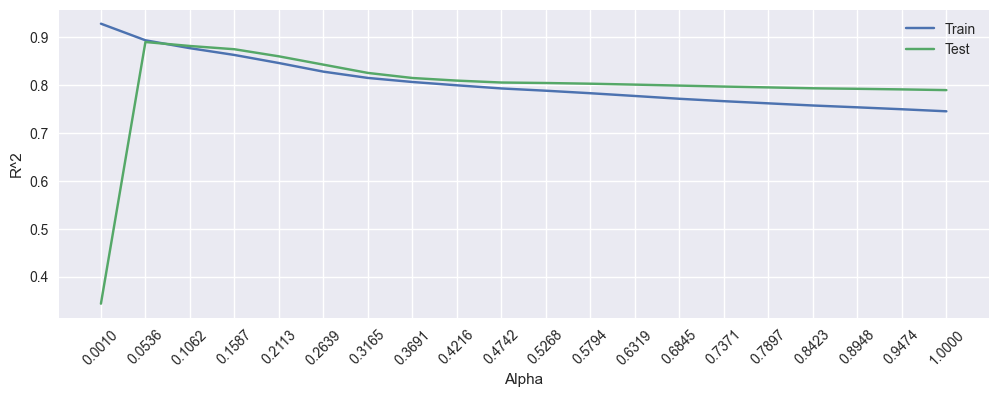

In [119]:
#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('R^2') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абсцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

С помощью графика мы можем подобрать оптимальное значение параметра alpha. Нам нужна такая точка на оси абсцисс, при которой на тестовой выборке наблюдается максимальная метрика и при этом разница между метриками на тренировочной и тестовой выборках минимальна.

Видно, что метрика на тестовой выборке достигает наибольшего значения в точке 0.0536. Причём в этой точке наблюдается примерное равенство метрик на каждом наборе данных. Далее метрика на тестовой выборке начинает падать.

Обратите внимание, что на тренировочной выборке метрика непрерывно падает с ростом alpha. Оно и понятно, ведь чем больше alpha, тем сильнее регуляризация и тем меньше модель подстраивается под обучающую выборку.

Давайте подставим значение alpha=0.0536 в модель Lasso и получим результат:

In [120]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.0536)
#Обучаем модель 
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.894
Test R^2: 0.890


Примечание. Регуляризация присутствует и в модели SGDRegressor, причём она используется по умолчанию. В инициализаторе данного класса есть параметр penalty, который позволяет управлять методом регуляризации. Параметр может принимать значения 'l1', 'l2' и 'elasticnet'. По умолчанию используется L2-регуляризация (penalty='l2'). Коэффициент регуляризации (alpha) по умолчанию равен 0.0001 (относительно слабая регуляризация). Управляя двумя этими параметрами, вы можете настраивать тип регуляризации в SGD-методе и её «силу».